# Getting some baseline

So, I've been tuning now this model for too long. Probably it is good to just get some simple baselines and compare it to them to see how good we are in the end. 

In [3]:
%load_ext autoreload
%autoreload 2
import joblib
import pandas as pd
import sys
sys.path.append('../')
from sklearn.preprocessing import StandardScaler
from colorml.utils import mapping_to_target_range, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig, read_pickle, augment_data
from colorml.descriptornames import * 

In [4]:
from sklearn.dummy import DummyRegressor

In [16]:
scaler = joblib.load('../work/2020513gpoutnoise/scaler.joblib')
vt = joblib.load('../work/2020513gpoutnoise/vt.joblib')
sfs = joblib.load('../work/2020513gpoutnoise/sfs.joblib')

In [21]:
df_train = pd.read_csv('../data/development_set.csv')
df_test = pd.read_csv('../data/holdout_set.csv')

In [18]:
CHEMICAL_FEATURES = (
        metalcenter_descriptors
        + functionalgroup_descriptors
        + linker_descriptors
        + mol_desc
        + summed_functionalgroup_descriptors
        + summed_linker_descriptors
        + summed_metalcenter_descriptors
    )

In [19]:
X_train = df_train[CHEMICAL_FEATURES]
X_test = df_test[CHEMICAL_FEATURES]

In [17]:
df_chris = pd.read_csv('../notebooks/chris_descriptors.csv')
df_new = pd.read_csv('../notebooks/new_descriptors.csv')

In [21]:
X_chris = df_chris[CHEMICAL_FEATURES]
X_new = df_new[CHEMICAL_FEATURES]

In [22]:
yscaler = StandardScaler()
y_train = yscaler.fit_transform(df_train[['r', 'g', 'b']])
y_test = yscaler.transform(df_test[['r', 'g', 'b']])

In [23]:
X_train = vt.transform(X_train)
X_test = vt.transform(X_test)
X_chris = vt.transform(X_chris)
X_new = vt.transform(X_new)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_chris = scaler.transform(X_chris)
X_new = scaler.transform(X_new)

In [12]:
feat = [0,
  4,
  5,
  34,
  36,
  45,
  47,
  56,
  72,
  74,
  84,
  114,
  137,
  139,
  149,
  151,
  176,
  178,
  188,
  190]

In [13]:
X_train = X_train[:, feat]
X_test = X_test[:, feat]
X_chris = X_chris[:, feat]
X_new = X_new[:, feat]

In [24]:
name_train = df_train['color_cleaned']
name_test = df_test['color_cleaned']

In [25]:
dummy_mean = DummyRegressor(strategy='mean')
dummy_median = DummyRegressor(strategy='median')

In [26]:
dummy_mean.fit(X_train, y_train)
dummy_median.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='median')

In [27]:
mean_prediction_test = dummy_mean.predict(X_test)
median_predicton_test = dummy_median.predict(X_test)

In [28]:

import matplotlib.pyplot as plt
%matplotlib inline
from webcolors import rgb_to_hex
import matplotlib.patches as mpatch

In [29]:
def plot_predictions(predictions, labels, names, sample=100, outname=None):
    """Plot figure that compares color of predictions versus acutal colors.
    
    Arguments:
        predictions {iterable} -- iterable of rgb colors
        labels {iterable} -- iterable of rgb colors
        names {iterable} -- iterable of strings
    
    Keyword Arguments:
        sample {int} -- how many samples to plot (default: {100})
        outname {string} -- path to which figure is saved (default: {None})
    """
    fig = plt.figure(figsize=[5, 8])
    ax = fig.add_axes([0, 0, 1, 1])

    predictions = predictions[:sample]
    names = names[:sample]
    labels = labels[:sample]

    predictions = [rgb_to_hex((int(c[0]), int(c[1]), int(c[2]))) for c in predictions]
    true = [rgb_to_hex((int(c[0]), int(c[1]), int(c[2]))) for c in labels]

    for i in range(len(predictions)):
        r1 = mpatch.Rectangle((0, i), 1, 1, color=predictions[i])
        r2 = mpatch.Rectangle((1, i), 1, 1, color=true[i])
        txt = ax.text(2, i + 0.5, "  " + names[i], va="center", fontsize=12)

        ax.add_patch(r1)
        ax.add_patch(r2)
        ax.axhline(i, color="k")

    ax.text(0.5, i + 1.5, "prediction", ha="center", va="center", fontsize=12)
    ax.text(1.5, i + 1.5, "median RGB for label", ha="center", va="center", fontsize=12)
    ax.set_xlim(0, 3)
    ax.set_ylim(0, i + 2)
    ax.axis("off")

    fig.tight_layout()
    
    if outname is not None: 
        fig.savefig(outname, bbox_inches='tight')


/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


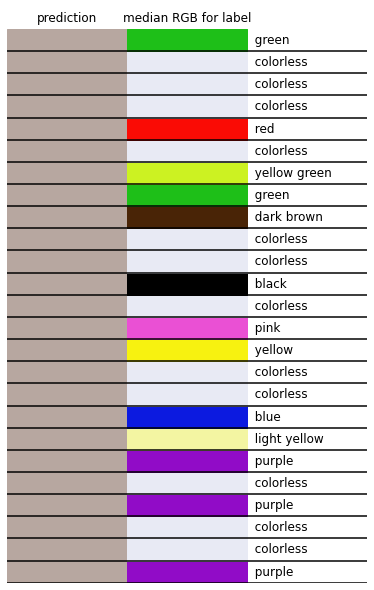

In [30]:
plot_predictions(yscaler.inverse_transform(mean_prediction_test), 
                 yscaler.inverse_transform(y_test),  name_test.values, 
                 sample=25, outname='mean_baseline.pdf')

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


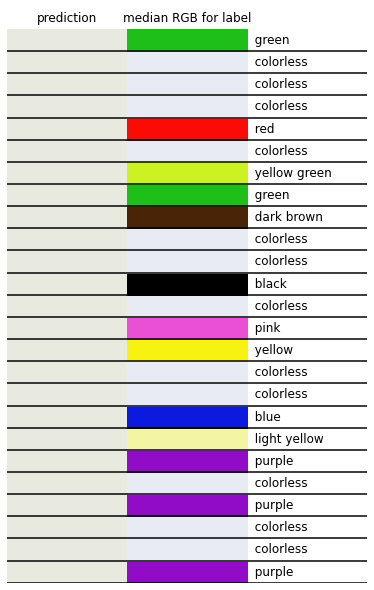

In [31]:
plot_predictions(yscaler.inverse_transform(median_predicton_test), 
                 yscaler.inverse_transform(y_test),  name_test.values, 
                 sample=25, outname='median_baseline.pdf')

In [32]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [33]:
def get_metrics(y_true, y_predicted):
    r2 = r2_score(y_true, y_predicted)
    mae = mean_absolute_error(y_true, y_predicted)
    mse = mean_squared_error(y_true, y_predicted)
    
    return {
        'r2': r2,
        'mae': mae,
        'mse': mse
    }

In [34]:
get_metrics(y_test, mean_prediction_test)

{'r2': -0.00123382032671282,
 'mae': 0.9095882198650823,
 'mse': 1.0437483663060771}

In [35]:
get_metrics(y_test, median_predicton_test)

{'r2': -0.41226718374253407,
 'mae': 0.7475809148961868,
 'mse': 1.471870948157506}

In [36]:
from sklearn.neighbors import KNeighborsRegressor

In [37]:
knn1 = KNeighborsRegressor(1)
knn4 = KNeighborsRegressor(4)

In [38]:
knn1.fit(X_train, y_train)
knn4.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

In [39]:
knn1_prediction = knn1.predict(X_test)

In [40]:
knn4_prediction = knn4.predict(X_test)

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


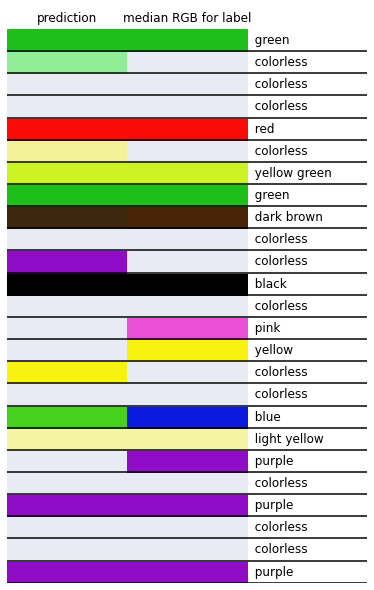

In [41]:
plot_predictions(yscaler.inverse_transform(knn1_prediction), 
                 yscaler.inverse_transform(y_test),  name_test.values, 
                 sample=25, outname='knn1_baseline.pdf')

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


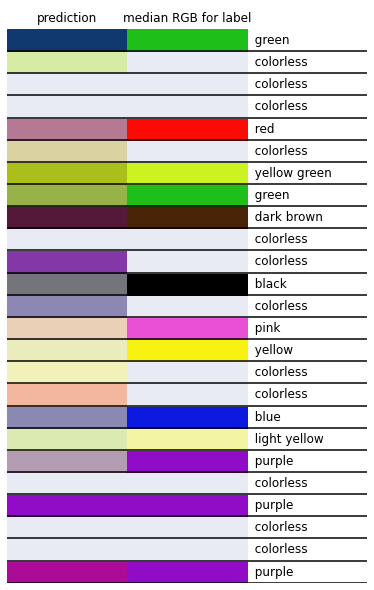

In [42]:
plot_predictions(yscaler.inverse_transform(knn4_prediction), 
                 yscaler.inverse_transform(y_test),  name_test.values, 
                 sample=25, outname='knn4_baseline.pdf')

In [43]:
get_metrics(y_test, knn1_prediction)

{'r2': 0.0385442949292207,
 'mae': 0.5249477657935612,
 'mse': 1.0015340363866634}

In [44]:
get_metrics(y_test, knn4_prediction)

{'r2': 0.24475977464798404,
 'mae': 0.6183640394547121,
 'mse': 0.7861595007965327}

In [45]:
from xgboost import XGBRegressor

In [46]:
from lightgbm import LGBMRegressor

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [47]:
lgbr = LGBMRegressor()

In [176]:
lgbrr = LGBMRegressor(n_estimators=5000, learning_rate=0.01, verbose_eval=4)
lgbrg = LGBMRegressor(n_estimators=5000, learning_rate=0.01, verbose_eval=4)
lgbrb = LGBMRegressor(n_estimators=5000, learning_rate=0.01, verbose_eval=4)

lgbrr.fit(X_train, y_train[:,0])
lgbrg.fit(X_train, y_train[:,1])
lgbrb.fit(X_train, y_train[:,2])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              verbose_eval=4)

In [178]:
lgbrr_prediction = lgbrr.predict(X_test)
lgbrg_prediction = lgbrg.predict(X_test)
lgbrb_prediction = lgbrb.predict(X_test)

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


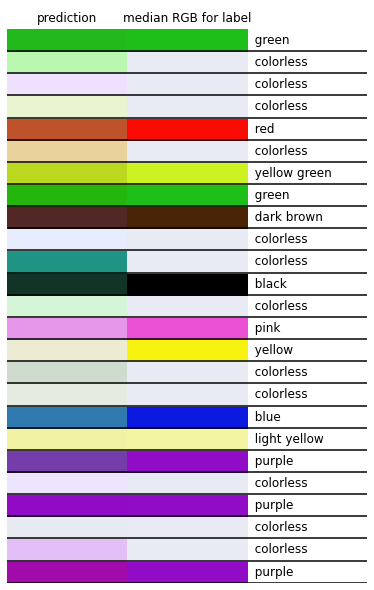

In [179]:
plot_predictions(yscaler.inverse_transform(np.hstack([lgbrr_prediction.reshape(-1,1), lgbrg_prediction.reshape(-1,1), lgbrb_prediction.reshape(-1,1)])), 
                 yscaler.inverse_transform(y_test),  name_test.values, 
                 sample=25, outname='lgb_baseline.pdf')

In [51]:
import numpy as np

In [58]:
1-0.866

0.134

In [68]:
quantile_alphas = [0.134, 0.5, 0.866]

lgb_quantile_alphas_r = {}
lgb_quantile_alphas_g = {}
lgb_quantile_alphas_b = {}
for quantile_alpha in quantile_alphas:
    # to train a quantile regression, we change the objective parameter and
    # specify the quantile value we're interested in
    lgb = LGBMRegressor(objective='quantile', alpha=quantile_alpha)
    lgb.fit(X_train, y_train[:,0])
    lgb_quantile_alphas_r[quantile_alpha] = lgb
    
    lgb.fit(X_train, y_train[:,1])
    lgb_quantile_alphas_g[quantile_alpha] = lgb
    
    lgb.fit(X_train, y_train[:,2])
    lgb_quantile_alphas_b[quantile_alpha] = lgb

In [61]:
yscaler.inverse_transform(np.array([lgb_quantile_alphas[0.134].predict(X_test[0:1])]*3).reshape(1,3))

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/lightgbm/basic.py:204: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


array([[133.15733102, 113.88502013, 101.06209986]])

In [63]:
yscaler.inverse_transform(np.array([lgb_quantile_alphas[0.5].predict(X_test[0:1])]*3).reshape(1,3))

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/lightgbm/basic.py:204: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


array([[145.35336245, 126.90635548, 115.42674408]])

In [62]:
yscaler.inverse_transform(np.array([lgb_quantile_alphas[0.866].predict(X_test[0:1])]*3).reshape(1,3))

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/lightgbm/basic.py:204: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


array([[238.57302206, 226.4341778 , 225.2220699 ]])

In [64]:
(238.57302206 - 145.35336245) / 1.5

62.146439740000005

In [67]:
(145.35336245 - 133.15733102) / 1.5

8.130687620000003

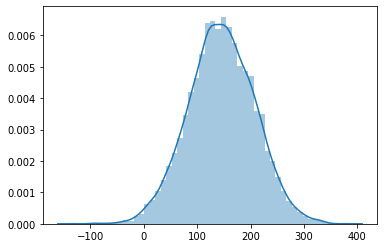

In [66]:
import scipy.stats
import seaborn as sns
distribution = scipy.stats.norm(loc=145.35336245, scale=62)
sample = distribution.rvs(size=10000)
sns.distplot(sample)
plt.show()

In [160]:
xgbrr = XGBRegressor(early_stopping_rounds=3, n_estimators=5000, learning_rate=0.01, verbose_eval=4)
xgbrg = XGBRegressor(early_stopping_rounds=3, n_estimators=5000, learning_rate=0.01, verbose_eval=4)
xgbrb = XGBRegressor(early_stopping_rounds=3, n_estimators=5000, learning_rate=0.01, verbose_eval=4)

In [161]:
xgbrr.fit(X_train, y_train[:,0])
xgbrg.fit(X_train, y_train[:,1])
xgbrb.fit(X_train, y_train[:,2])

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=3,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=5000, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbose_eval=4,
             verbosity=None)

In [ ]:
xgbrb

In [138]:
import numpy as np

In [163]:
xgbrr_prediction = xgbrr.predict(X_test)
xgbrg_prediction = xgbrg.predict(X_test)
xgbrb_prediction = xgbrb.predict(X_test)

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


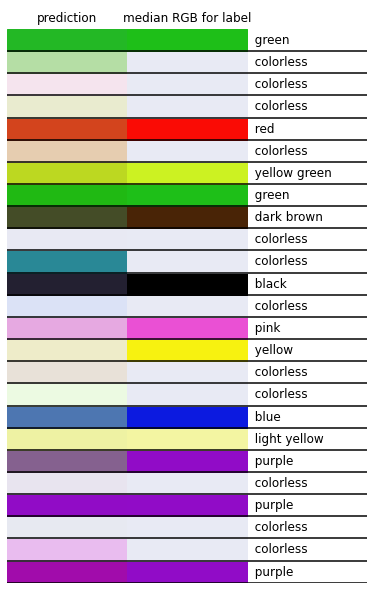

In [164]:
plot_predictions(yscaler.inverse_transform(np.hstack([xgbrr_prediction.reshape(-1,1), xgbrg_prediction.reshape(-1,1), xgbrb_prediction.reshape(-1,1)])), 
                 yscaler.inverse_transform(y_test),  name_test.values, 
                 sample=25, outname='xgb_baseline.pdf')

In [165]:
get_metrics(y_test, np.hstack([xgbrr_prediction.reshape(-1,1), xgbrg_prediction.reshape(-1,1), xgbrb_prediction.reshape(-1,1)]))

{'r2': 0.5148749275762976,
 'mae': 0.4481284017329439,
 'mse': 0.5028120556074015}

In [166]:
xgbrr_prediction = xgbrr.predict(X_new)
xgbrg_prediction = xgbrg.predict(X_new)
xgbrb_prediction = xgbrb.predict(X_new)

In [167]:
xgbprediction = np.hstack([xgbrr_prediction.reshape(-1,1), xgbrg_prediction.reshape(-1,1), xgbrb_prediction.reshape(-1,1)])

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


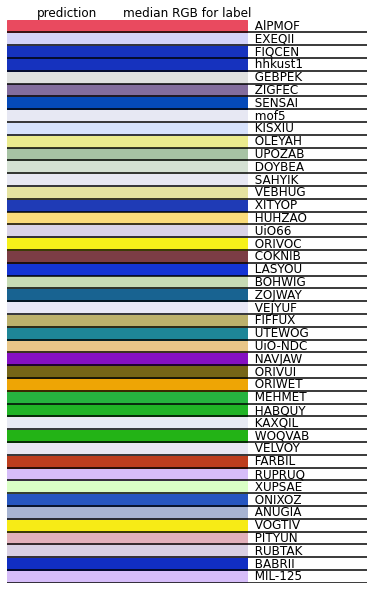

In [168]:
plot_predictions(yscaler.inverse_transform(xgbprediction), yscaler.inverse_transform(xgbprediction), df_new['name'])

In [8]:
augmentation_dict = read_pickle('../data/augment_dict.pkl')

In [6]:
from colorml.utils import plot_prediction_dist

In [83]:
import numpy as np 


yscaler = joblib.load('../colorml/yscaler_run_2020_05_25_19_27_1590427678.joblib')
X_test = np.load('../colorml/X_test_run_2020_05_25_19_27_1590427678.npy')
names = np.load('../colorml/y_names_run_2020_05_25_19_27_1590427678.npy', allow_pickle=True)
mean = joblib.load('../colorml/regressor_meanrun_2020_05_25_19_27_1590427678.joblib')
median = joblib.load('../colorml/regressor_medianrun_2020_05_25_19_27_1590427678.joblib')
quantile01 = joblib.load('../colorml/regressor_0_1run_2020_05_25_19_27_1590427678.joblib') 
quantile09 = joblib.load('../colorml/regressor_0_9run_2020_05_25_19_27_1590427678.joblib')
vt = joblib.load('../colorml/vt_run_2020_05_25_19_27_1590427678.joblib')
scaler = joblib.load('../colorml/scaler_run_2020_05_25_19_27_1590427678.joblib')


In [95]:
median_prediction = median.predict(X_test)
quantile01_prediction = quantile01.predict(X_test)
quantile09_prediction = quantile09.predict(X_test)

../colorml/utils.py:385: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


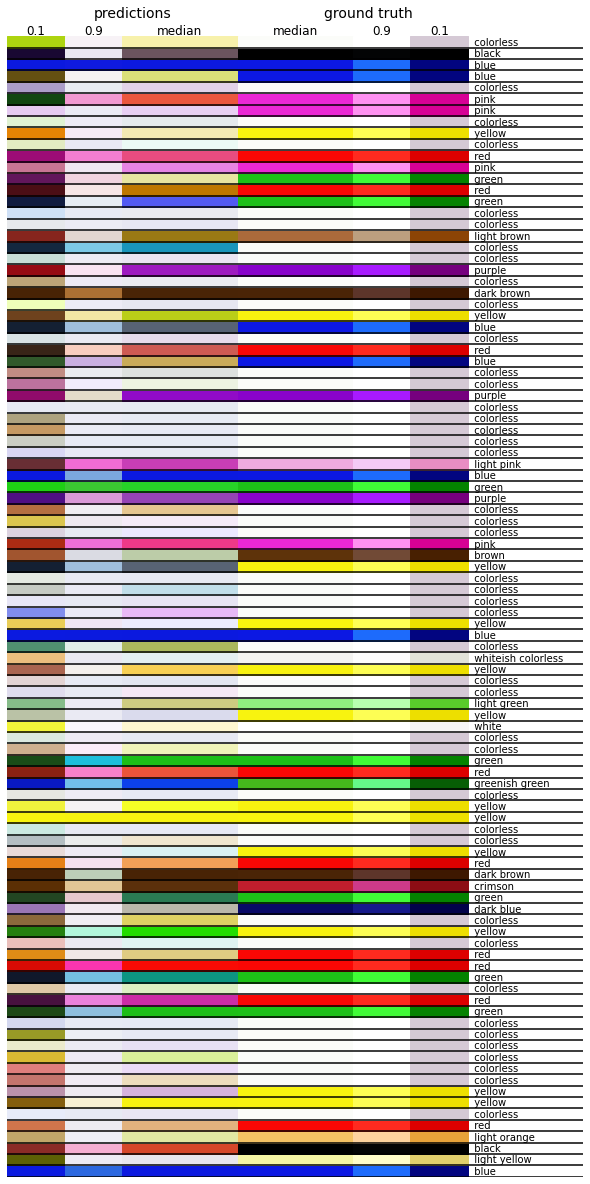

In [102]:
plot_prediction_dist(yscaler.inverse_transform(quantile01_prediction), 
                     yscaler.inverse_transform(median_prediction), 
                     yscaler.inverse_transform(quantile09_prediction),
                     names,
                     augmentation_dict, 
                     100
                    )

In [ ]:
median

In [104]:
medianrt shap

[autoreload of pyparsing failed: Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 287, in update_class
    old_obj = getattr(old, key)
  File "/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/pyparsing.py", line 6712, in __get__
    cls._intern[attrname] = self.fn(cls)
  File "/Users/kevinmaikjablonka/opt/min